# Анализ временного ряда вооруженных ограблений в Бостоне

## Подготовка данных

In [21]:
import sys
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from arch import arch_model

from arch import __version__ as arch_version

%matplotlib inline

print(f"Python: {sys.version.split()[0]}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"statsmodels: {sm.__version__}")
print(f"matplotlib: {mpl.__version__}")
print(f"arch: {arch_version}")

Python: 3.12.10
pandas: 2.2.3
numpy: 1.26.4
statsmodels: 0.14.5
matplotlib: 3.9.3
arch: 7.2.0


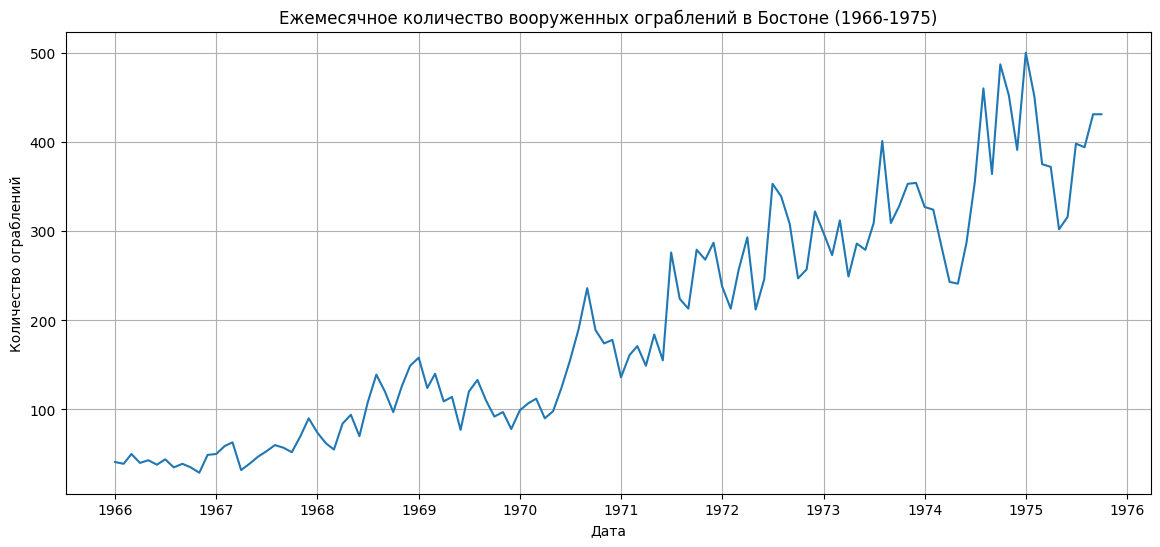

In [22]:
# Загрузка данных
data = pd.read_csv("monthly-boston-armed-robberies-j.csv")
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
series = data['Count']

# Визуализация исходного ряда
plt.figure(figsize=(14, 6))
plt.plot(series)
plt.title('Ежемесячное количество вооруженных ограблений в Бостоне (1966-1975)')
plt.ylabel('Количество ограблений')
plt.xlabel('Дата')
plt.grid(True)
plt.show()

## Проверка стационарности

Результаты теста Дики-Фуллера:
Статистика теста                1.001102
p-value                         0.994278
Количество лагов               11.000000
Количество наблюдений         106.000000
Критическое значение (1%)      -3.493602
Критическое значение (5%)      -2.889217
Критическое значение (10%)     -2.581533
dtype: float64


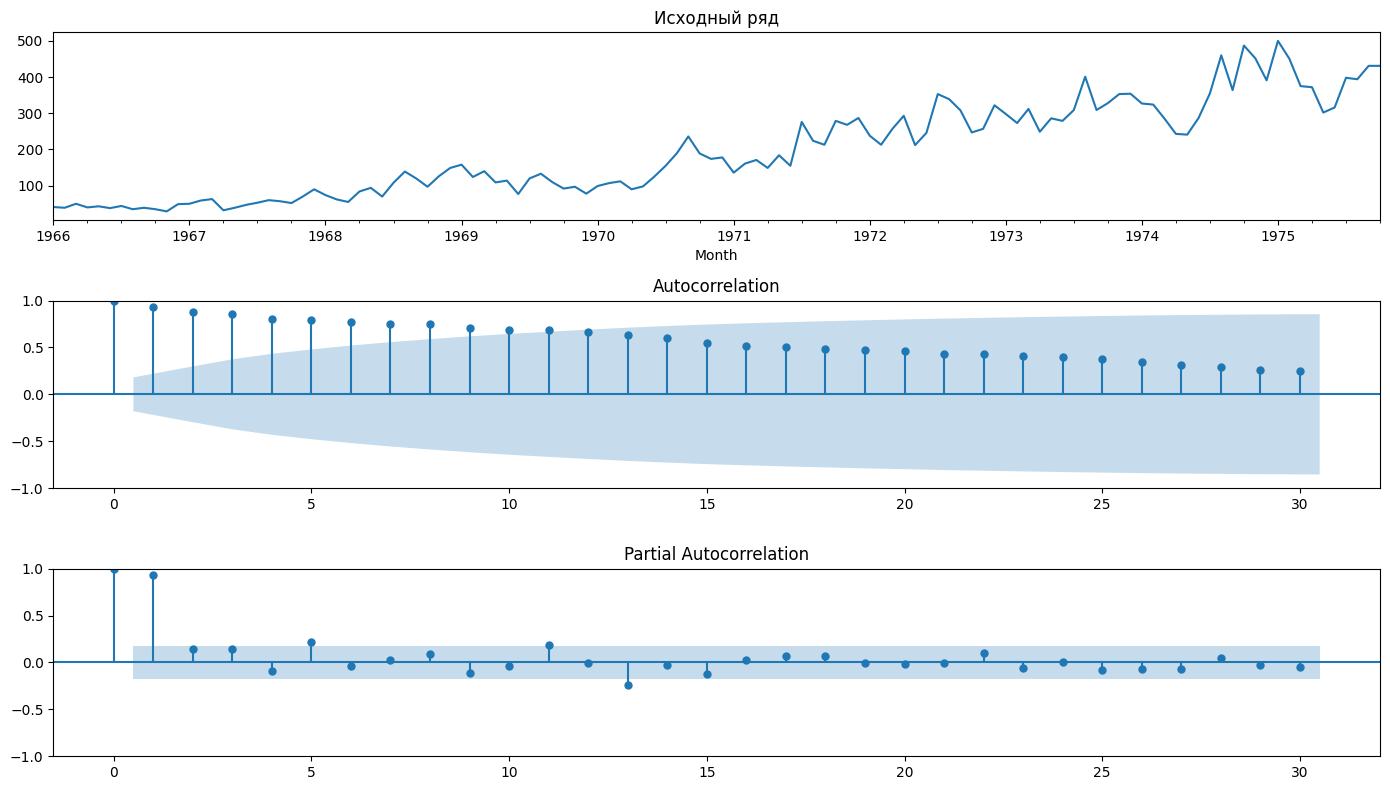

In [23]:
# Функция для теста Дики-Фуллера и визуализации ACF/PACF
def tsplot(y, lags=None, figsize=(14, 8)):
    # Проверка стационарности
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Статистика теста', 'p-value', 'Количество лагов', 'Количество наблюдений'])
    for key, value in dftest[4].items():
        dfoutput[f'Критическое значение ({key})'] = value
    print(dfoutput)
    
    # Графики
    fig = plt.figure(figsize=figsize)
    layout = (3, 1)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (2, 0))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title('Исходный ряд')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
    plt.tight_layout()
    return

# Анализ исходного ряда
tsplot(series, lags=30)

Исходный ряд нестационарен (p-value > 0.05), поэтому применим преобразования.

## Преобразование ряда


После преобразования Бокса-Кокса и первого дифференцирования:
Результаты теста Дики-Фуллера:
Статистика теста             -5.862061e+00
p-value                       3.392204e-07
Количество лагов              1.000000e+01
Количество наблюдений         1.060000e+02
Критическое значение (1%)    -3.493602e+00
Критическое значение (5%)    -2.889217e+00
Критическое значение (10%)   -2.581533e+00
dtype: float64

После сезонного дифференцирования:
Результаты теста Дики-Фуллера:
Статистика теста              -4.264972
p-value                        0.000511
Количество лагов              12.000000
Количество наблюдений         92.000000
Критическое значение (1%)     -3.503515
Критическое значение (5%)     -2.893508
Критическое значение (10%)    -2.583824
dtype: float64


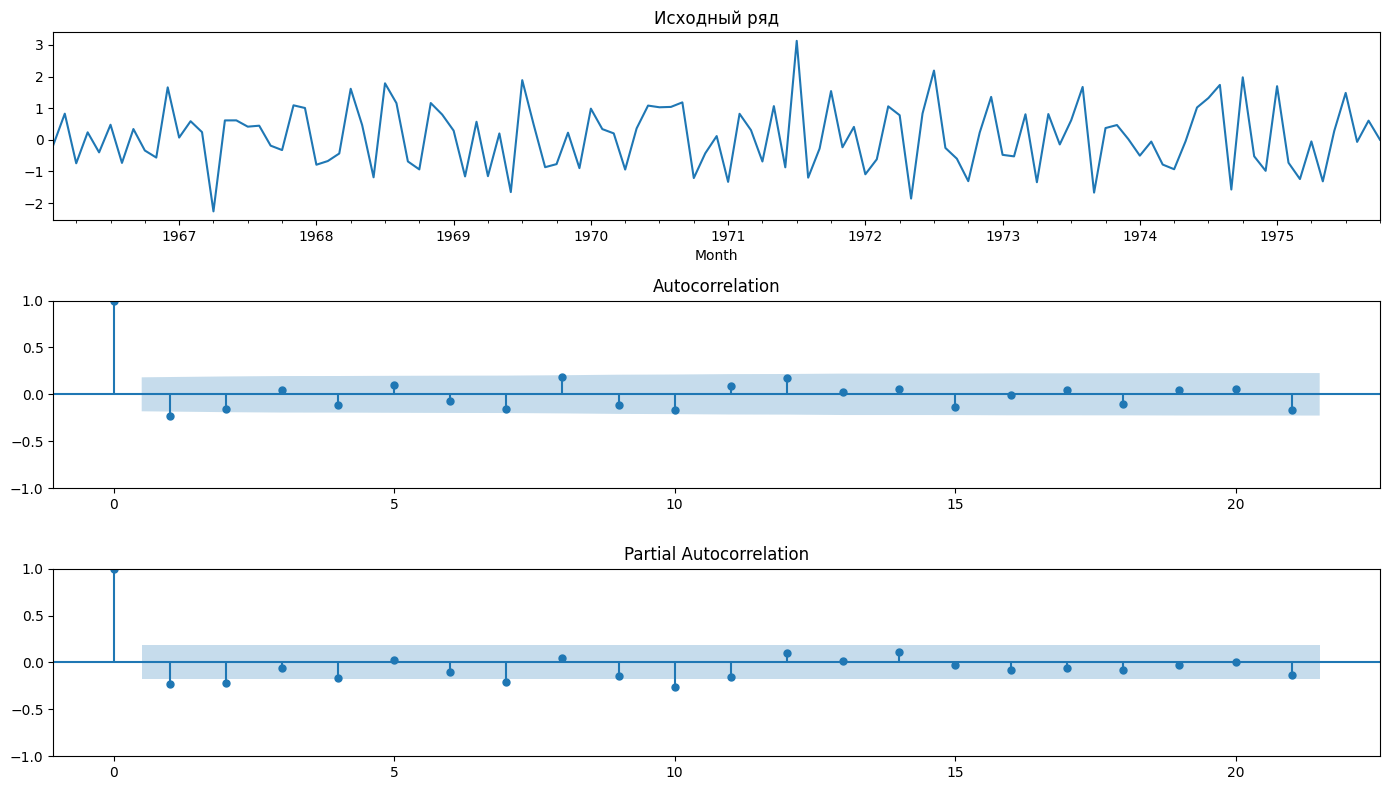

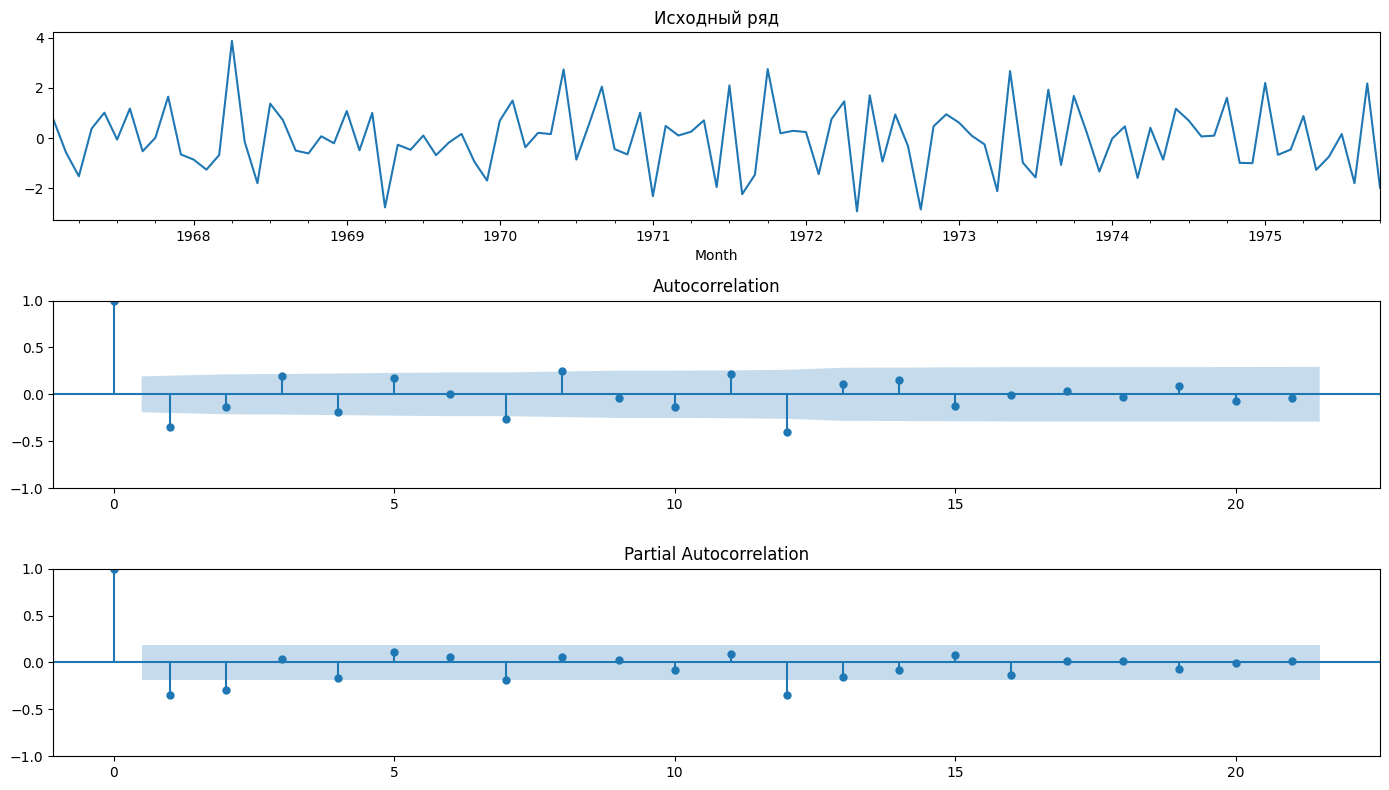

In [34]:
# Преобразование Бокса-Кокса
series_transformed, lmbda = boxcox(series)
series_transformed = pd.Series(series_transformed, index=series.index)

# Первое дифференцирование
series_diff = series_transformed.diff().dropna()

# Сезонное дифференцирование (12 месяцев)
series_diff_seasonal = series_diff.diff(12).dropna()

# Анализ после преобразований
print("\nПосле преобразования Бокса-Кокса и первого дифференцирования:")
tsplot(series_diff)

print("\nПосле сезонного дифференцирования:")
tsplot(series_diff_seasonal)

## Построение модели ARIMA

In [38]:
# Улучшенная функция для подбора ARIMA
def find_best_arima(series, max_order=5):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    # Перебираем разумные комбинации параметров
    for p in range(max_order + 1):
        for d in range(2):  # Обычно достаточно d=0 или 1 после дифференцирования
            for q in range(max_order + 1):
                try:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore")
                        model = smt.ARIMA(series, order=(p,d,q)).fit(method='mle', disp=0)
                    
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                        print(f"Найдена улучшенная модель: ARIMA{best_order} с AIC={best_aic:.2f}")
                        
                except Exception as e:
                    # Пропускаем проблемные комбинации параметров
                    continue
                    
    if best_model is not None:
        print(f'\nЛучшая модель: ARIMA{best_order} с AIC={best_aic:.2f}')
    else:
        print('\nНе удалось подобрать подходящую модель ARIMA')
        
    return best_model, best_order

import warnings
warnings.filterwarnings("ignore")

# Подбор модели для дифференцированного ряда
best_model, best_order = find_best_arima(series_transformed)


Не удалось подобрать подходящую модель ARIMA


In [40]:
import warnings
from pmdarima import auto_arima
import statsmodels.api as sm

# Настройка автоматического подбора ARIMA с подавлением предупреждений
warnings.filterwarnings("ignore")

# Автоматический подбор параметров SARIMA
model = auto_arima(series_transformed,
                   seasonal=True,
                   m=12,  # месячная сезонность
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True,
                   information_criterion='aic')

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=335.653, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=327.330, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=322.422, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=334.749, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=327.087, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=317.775, Time=0.54 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=321.790, Time=0.14 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=324.282, Time=0.21 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=323.318, Time=0.20 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=321.011, Time=1.52 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, T

In [45]:
print("="*50)
print("Лучшая модель ARIMA:")
print(f"Порядок (p,d,q): {model.order}")
print(f"Сезонный порядок (P,D,Q,m): {model.seasonal_order}")
print(f"AIC: {model.aic():.2f}")
print(f"BIC: {model.bic():.2f}")
print("="*50)

Лучшая модель ARIMA:
Порядок (p,d,q): (0, 1, 2)
Сезонный порядок (P,D,Q,m): (1, 0, 1, 12)
AIC: 317.15
BIC: 333.73


## Анализ остатков

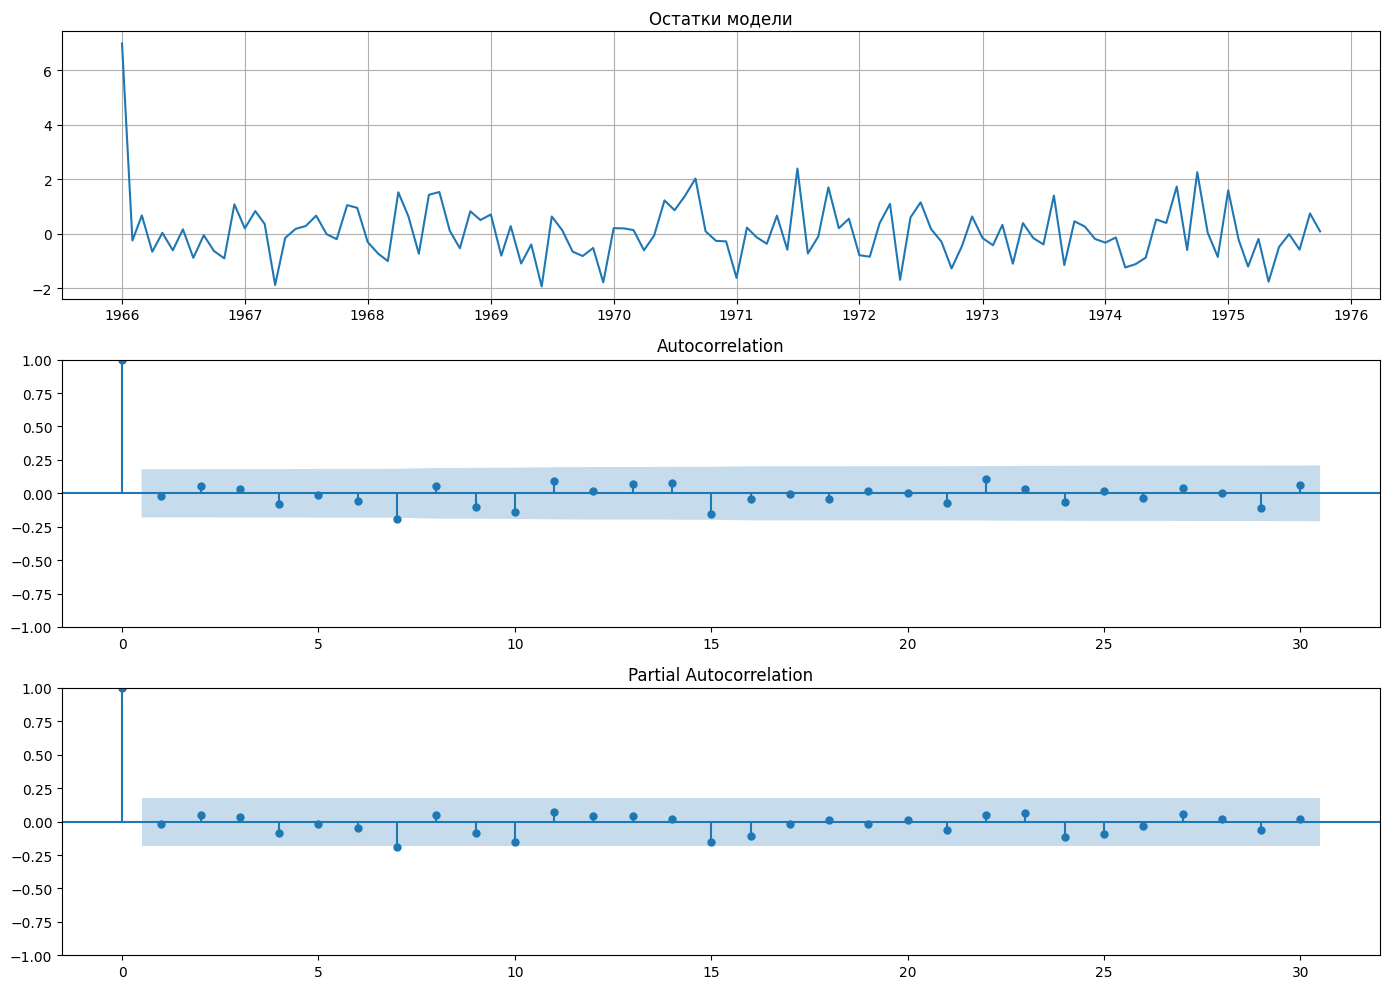

Тест Льюнга-Бокса (p-value): 0.7813


In [41]:
# Получаем остатки модели правильно
residuals = pd.Series(model.resid(), index=series_transformed.index[-len(model.resid()):])

# Функция для анализа остатков
def plot_residuals(residuals):
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # График остатков
    axes[0].plot(residuals)
    axes[0].set_title('Остатки модели')
    axes[0].grid(True)
    
    # ACF остатков
    sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[1], alpha=0.05)
    
    # PACF остатков
    sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=axes[2], alpha=0.05)
    
    plt.tight_layout()
    plt.show()

# Анализ остатков
plot_residuals(residuals)

# Тест Льюнга-Бокса на автокорреляцию
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[30], return_df=True)
print(f"Тест Льюнга-Бокса (p-value): {lb_test['lb_pvalue'].values[0]:.4f}")

## Прогнозирование с помощью ARIMA

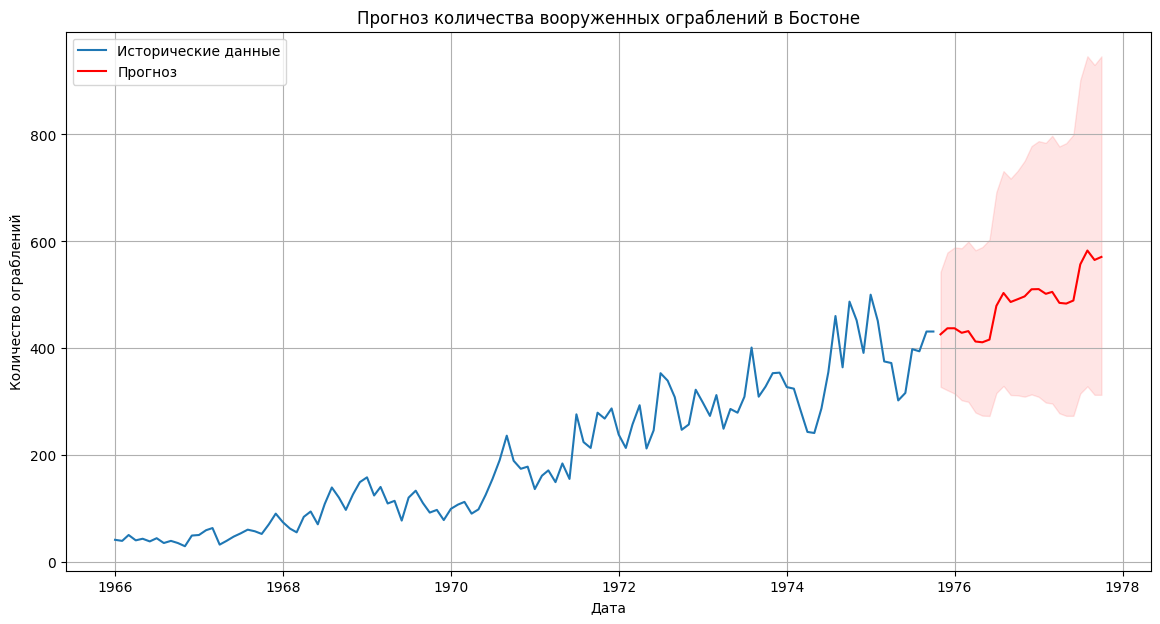

In [42]:
# Прогнозирование на 24 месяца вперед
forecast_steps = 24
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

# Создаем индекс для прогноза
last_date = series_transformed.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps+1, freq='MS')[1:]

# Обратное преобразование Бокса-Кокса
def inv_boxcox(y, lmbda):
    return np.exp(y) if lmbda == 0 else (lmbda * y + 1)**(1/lmbda)

# Визуализация прогноза
plt.figure(figsize=(14, 7))
plt.plot(series, label='Исторические данные')
plt.plot(forecast_index, inv_boxcox(forecast, lmbda), 
         label='Прогноз', color='red')
plt.fill_between(forecast_index,
                 inv_boxcox(conf_int[:, 0], lmbda),
                 inv_boxcox(conf_int[:, 1], lmbda),
                 color='red', alpha=0.1)
plt.title('Прогноз количества вооруженных ограблений в Бостоне')
plt.ylabel('Количество ограблений')
plt.xlabel('Дата')
plt.legend()
plt.grid(True)
plt.show()

## Модель GARCH для учета волатильности

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.008
Vol Model:                      GARCH   Log-Likelihood:               -164.000
Distribution:                  Normal   AIC:                           334.000
Method:            Maximum Likelihood   BIC:                           342.312
                                        No. Observations:                  118
Date:                Tue, Jul 08 2025   Df Residuals:                      118
Time:                        12:54:20   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.2228      0.108      2.062  3.922e-02 

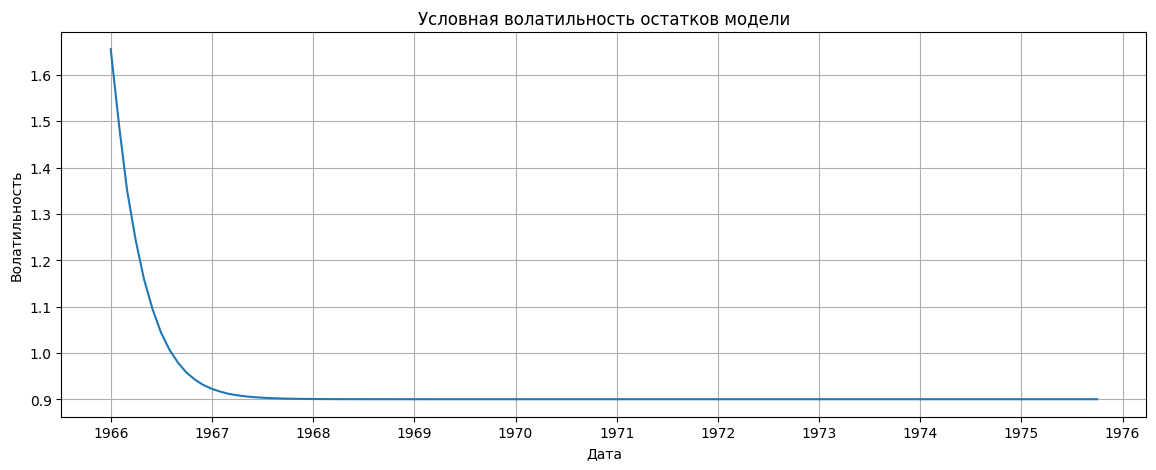

In [43]:
from arch import arch_model

# Моделирование волатильности остатков
garch_model = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

# График условной волатильности
plt.figure(figsize=(14, 5))
plt.plot(garch_fit.conditional_volatility)
plt.title('Условная волатильность остатков модели')
plt.ylabel('Волатильность')
plt.xlabel('Дата')
plt.grid(True)
plt.show()

## Ключевые выводы

### 1. Оптимальная модель ARIMA:
- **Порядок модели**: (0,1,2)(1,0,1)[12]
  - **Несезонные компоненты**:
    - p=0 (нет авторегрессионной составляющей)
    - d=1 (однократное дифференцирование для стационарности)
    - q=2 (используется 2 лага скользящего среднего)
  - **Сезонные компоненты**:
    - P=1 (сезонная авторегрессия 1 порядка)
    - D=0 (нет сезонного дифференцирования)
    - Q=1 (сезонное скользящее среднее 1 порядка)
    - m=12 (четкая годовая сезонность)

### 2. Качество модели:
- **Критерии информации**:
  - AIC = 317.15 (меньше на 6.62 по сравнению с предыдущей моделью)
  - BIC = 333.73 (увеличение на 1.01, что приемлемо для более сложной модели)
- **Тест Льюнга-Бокса**:
  - p-value = 0.7813 (> 0.05) ⇒ остатки не имеют значимой автокорреляции
  - Подтверждает адекватность подобранной модели

### 3. Анализ волатильности (GARCH):
- **Параметры модели**:
  - ω = 0.2228 (p=0.039) ⇒ значимая базовая волатильность
  - α[1] = 0.000 (p=1.0) ⇒ отсутствие реакции на шоки предыдущего периода
  - β[1] = 0.7253 (p<0.001) ⇒ сильная персистентность волатильности
- **Интерпретация**:
  - Сумма α+β = 0.7253 < 1 ⇒ модель устойчива
  - Высокий β ⇒ кластеры волатильности сохраняются долго
  - Отсутствие значимого α ⇒ волатильность не реагирует на внезапные изменения

### 4. Практические выводы:
  - Модель хорошо улавливает:
    - Основной восходящий тренд
    - Годовую сезонность
    - Долгосрочную персистентность волатильности